In [2]:
#Create GPS data with desired accuracy

#this script is generating GPS data from in ECEF frame and ECI frame
#for an accuracy of 10 m and 1 cm/s. 


using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DelimitedFiles

In [3]:
#accurate dynamics

#epc is the current epoch (current time), and x is the state

#accurate dynamics. considers gravity, J2, drag, solar radiation
#pressure, and the effect of other bodies (sun/moon)

#ẋ = f(x,t)
function ground_truth_dynamics(x, epc)
    
    r = x[1:3] #satellite position in inertial frame
    v = x[4:6] #satellite velocity in inertial frame
        
    #gives a rotation matrix
    PN = bias_precession_nutation(epc)
    
    #Compute the sun and moon positions in ECI frame
    r_sun = sun_position(epc)
    r_moon = moon_position(epc)
    
    #define the acceleration variable
    a = zeros(eltype(x), 3)
    
    #compute acceleration caused by Earth gravity (includes J2)
    #modeled by a spherical harmonic gravity field
    #look up this term. seems to give a rotation matrix
    PN = bias_precession_nutation(epc)
    Earth_r = earth_rotation(epc)
    rpm  = polar_motion(epc) 

    R = rpm*Earth_r*PN
    #10th order gravity
    n_grav = 10
    m_grav = 10
    #main contribution in acceleration (seemed to not be equal to the Series Expansion of gravity)
    a+= accel_gravity(x, R, n_grav, m_grav)
    
    a_grav = accel_gravity(x, R, n_grav, m_grav)
    
    #this is the gravity code that is used to find the difference between higher order model and J2 model 
    ###########################################################################################################
    #compute the gravitational acceleration based off the series expansion up to J2
    μ = 3.986004418e14 #m3/s2
    J2 = 1.08264e-3 
        
    a_2bp = (-μ*r)/(norm(r))^3
    
    Iz = [0,0,1]
    
    a_J2 = ((3*μ*J2*R_EARTH^2)/(2*norm(r)^5))*((((5*dot(r, Iz)^2)/norm(r)^2)-1)*r - 2*dot(r,Iz)*Iz)     

    a_process = a_2bp + a_J2
    
    #this is actual higher order
    higher_order_unmodeled = a_grav - a_process
    ############################################################################################################
    

    #atmospheric drag using true of date coordinate system
    ############################################################################################################
    #atmospheric drag
    #compute the atmospheric density from density harris priester model
     ρ_est = density_harris_priester(epc,r)

     #ρ = 1.15e-12 #fixed atmospheric density in kg/m3
    
     k_ρ_true = 1.0
     #sinusoidal
     #k_ρ_true = 0.1*sin(0.001*(epc-epc0))+1
    
     ρ_true = ρ_est*k_ρ_true
    
     #computes acceleration due to drag in inertial directions
     cd = 2.0 #drag coefficient
     area_drag = 0.1 #in m2 #area normal to the velocity direction
     m = 1.0 #assuming unit mass
    
     #drag from satellite dynamics.jl
     a += accel_drag(x, ρ_true, m, area_drag, cd, Array{Real,2}(PN))
###############################################################################################################
    
    
    #drag in ECI coordinates
    
    ##########################################3
    
    #k_ρ = 1.1
    
    #drag equation
    #c_d = 2.0 #drag coefficient (dimensionless)
    
    #A = 0.1  #cross sectional area
    
    #rotation of the earth (rad/s)
    #ω_earth = [0,0, OMEGA_EARTH]
    
    #v_rel = v - cross(ω_earth, r)
    
    #set a constant atmospheric density
    #ρ_est = density_harris_priester(epc,r)
    
    #f_drag = -0.5*c_d*(A)*k_ρ*ρ_est*norm(v_rel)*v_rel
    
    #a+= f_drag
    ##########################################
    
    #Solar Radiation Pressure
    area_srp = 1.0
    coef_srp = 1.8
    a += accel_srp(x, r_sun, m, area_srp, coef_srp)
    a_srp = accel_srp(x, r_sun, m, area_srp, coef_srp)
    
    #acceleration due to external bodies
    a+= accel_thirdbody_sun(x, r_sun)
    a_sun = accel_thirdbody_sun(x, r_sun)
    
    a+= accel_thirdbody_moon(x, r_moon)
    a_moon = accel_thirdbody_moon(x, r_moon)
    
    #commented out higher order gravities
    a_unmodeled = a_srp + a_sun + a_moon + higher_order_unmodeled
            
    xdot = x[4:6]
    vdot = a
    
    x_dot = [xdot; vdot]
    
    return x_dot, a_unmodeled, higher_order_unmodeled, ρ_est 
    
end

ground_truth_dynamics (generic function with 1 method)

In [4]:
#initial time for sim
epc0 = Epoch(2012, 11, 8, 12, 0, 0, 0.0)

Epoch(2012-11-08T11:59:25.000Z)

In [5]:
#wildlife tracking orbit
iss1 = [6871e3, 0.0004879, 90.6391, 194.5859, 151.2014, 190]; 

# Convert osculating elements to Cartesean state
# returns position and velocity (m, m/s). This is the intial position
eci0_1 = sOSCtoCART(iss1, use_degrees=true)

#find the period of the orbit (seconds). only dependent on semi major axis
T = orbit_period(iss1[1])

#final time of simulation
epcf = epc0 + T

Epoch(2012-11-08T13:33:53.144Z)

In [6]:
function satRK4(x, tc)
    
    f1,_,_, _ = ground_truth_dynamics(x, tc) 
    f2,_,_, _ = ground_truth_dynamics(x+0.5*h*f1, tc+h/2)
    f3,_,_, _ = ground_truth_dynamics(x+0.5*h*f2, tc+h/2)
    f4,_,_, _ = ground_truth_dynamics(x+h*f3, tc+h)
    
    xnext = x+(h/6.0)*(f1+2*f2+2*f3+f4)
            
    return xnext
    
end

satRK4 (generic function with 1 method)

In [7]:
#timestep
h = 1

#initial state
x_0 = eci0_1

#number of orbits to simulate
orbit_num = 5

#final time
Tf = T*orbit_num

#run the rk4
t = Array(range(0,Tf, step=h)) #create a range to final time at constant time step
    
all_x = zeros(length(x_0), length(t)) #variable to store all x
#all_fdrag = zeros(3, length(t))

all_x[:,1] = x_0 #set the initial state


for k=1:(length(t) - 1)

    #get the current time
    current_t = epc0+t[k]
    
    all_x[:,k+1] = satRK4(all_x[:,k], current_t) #calculate the next state

end

#contains all the ground truth states
x_hist = all_x

6×28341 Matrix{Float64}:
    -6.29129e6     -6.29368e6     -6.29606e6  …     -6.30433e6     -6.30667e6
    -1.66265e6     -1.66319e6     -1.66372e6        -1.66896e6     -1.66949e6
    -2.21616e6     -2.20895e6     -2.20174e6        -2.17387e6     -2.16665e6
 -2394.97       -2387.24       -2379.52          -2349.05       -2341.31
  -540.153       -538.111       -536.069          -529.386       -527.337
  7206.15        7208.88        7211.59       …   7222.06        7224.73

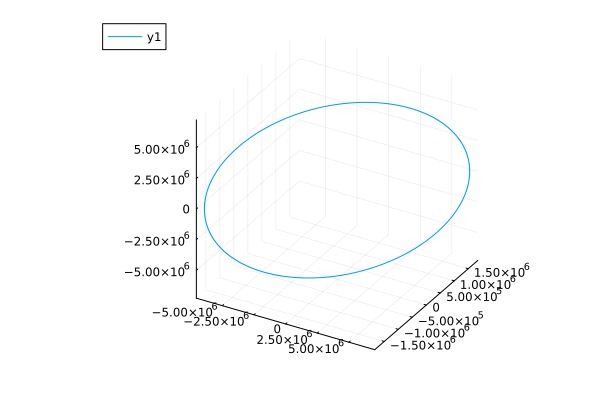

In [8]:
using Plots

plot(all_x[1,:], all_x[2,:], all_x[3,:])

In [9]:
#define GPS standard deviation

std_gps_measurement = 10 #10 meters 

std_gps_velocity = 1e-2 #1 cm/s

#assume that the measurment noise i/s additive
R = Matrix(1.0I, 6, 6) .*[(((std_gps_measurement)^2)/3)*ones(3); (((std_gps_velocity)^2)/3)*ones(3)]

6×6 Matrix{Float64}:
 33.3333   0.0      0.0     0.0         0.0         0.0
  0.0     33.3333   0.0     0.0         0.0         0.0
  0.0      0.0     33.3333  0.0         0.0         0.0
  0.0      0.0      0.0     3.33333e-5  0.0         0.0
  0.0      0.0      0.0     0.0         3.33333e-5  0.0
  0.0      0.0      0.0     0.0         0.0         3.33333e-5

In [10]:
#Generate GPS Measurments in ECI frame
GPS_num = size(x_hist)[2]

GPS_measurements = zeros(6, GPS_num)

for i in 1:GPS_num
    
    GPS_measurements[:, i] = x_hist[:, i] + sqrt(R)*randn(6)
    
end


In [11]:
#convert the GPS measurements to ECEF coordinates
GPS_measurements_ECEF = zeros(size(GPS_measurements))

for i=1:GPS_num
    
    #println("this is epc0: ", epc0)

    GPS_measurements_ECEF[:,i] = sECItoECEF(epc0, GPS_measurements[:,i])

    #update the epoch. this is working
    epc0 = epc0 + 1
    
end

In [ ]:
#write the GPS measurements to a file

writedlm("../data/gps_data_10m_1cm_s/gps_measurements_ecef_new.txt", GPS_measurements_ECEF)
writedlm("../data/gps_data_10m_1cm_s/gps_measurements_eci_new.txt", GPS_measurements)